<a href="https://colab.research.google.com/github/c-etulle/Vegetation-dynamics-in-the-Subandean-grasslands-of-Chubut/blob/main/8_Correlations_only_dry_season.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.) Calculate the median NDVI for each site, for all dry seasons.
Fx, for each site, calculate the median NDVI for Dec 2000 to Mar 2001; for Dec 2001 to Mar 2002 and so on. there should be around 103x22 NDVI values now. We should have it so that the dry season from Dec 2000 to mar 2001 is referred to as the dry season of "2000".

2.) Calculate the sum SPEI for the entire year relating to each dry season. This could be for example the period from April 1st. to Mar 31st. In this case, we have the SPEI balance of the entire year.

3.) When we have these values, we can correlate the SPEI balance for each season with the dry season NDVI.

# Packages

In [ ]:
%pip install unidecode
import re
import unidecode as unidecode
import numpy as np
import pandas as pd
import os, sys
from google.colab import drive


import glob
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import geopandas as gpd

import time
import fnmatch
import plotly.graph_objs as go
import plotly.express as px
from scipy import stats

from unidecode import unidecode
from scipy.stats import zscore


# Set working directory

In [ ]:
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/ee-meinzinger-patagonia

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ee-meinzinger-patagonia


# Define faulty locations

In [ ]:
# Create a list of faulty SPEI locations
faulty_locations = [
    "Cerro Condor",
    "La Clara",
    "Berna",
    "Bahia Cracker",
    "Valdes Creek Secc La Adela",
    "La Esperanza Biedma"
]

# Test
print(faulty_locations)

['Cerro Condor', 'La Clara', 'Berna', 'Bahia Cracker', 'Valdes Creek Secc La Adela', 'La Esperanza Biedma']


# Import data

## Import NDVI data

In [ ]:
path = "Data/landsat-2000-2024"

# find all the files that end with '_NDVI.csv'
csv_files = glob.glob(os.path.join(path, '*_NDVI.csv'))

# test
print(csv_files)

['Data/landsat-2000-2024/La Ana_NDVI.csv', 'Data/landsat-2000-2024/CERM_NDVI.csv', 'Data/landsat-2000-2024/Alto Rio Mayo_NDVI.csv', 'Data/landsat-2000-2024/Media Luna_NDVI.csv', 'Data/landsat-2000-2024/1 San Felipe_NDVI.csv', 'Data/landsat-2000-2024/Cerro Condor_NDVI.csv', 'Data/landsat-2000-2024/2 San Felipe_NDVI.csv', 'Data/landsat-2000-2024/La Isabel_NDVI.csv', 'Data/landsat-2000-2024/La Clara_NDVI.csv', 'Data/landsat-2000-2024/Berna_NDVI.csv', 'Data/landsat-2000-2024/Las Piedritas_NDVI.csv', 'Data/landsat-2000-2024/Bahia Cracker_NDVI.csv', 'Data/landsat-2000-2024/San Sebastian_NDVI.csv', 'Data/landsat-2000-2024/Bella Vista_NDVI.csv', 'Data/landsat-2000-2024/La Regina_NDVI.csv', 'Data/landsat-2000-2024/La Payanca_NDVI.csv', 'Data/landsat-2000-2024/Los 5 Hermanos_NDVI.csv', 'Data/landsat-2000-2024/Cerco de Piedras_NDVI.csv', 'Data/landsat-2000-2024/Chacra Berwyn_NDVI.csv', 'Data/landsat-2000-2024/El Moro_NDVI.csv', 'Data/landsat-2000-2024/1 San Jose_NDVI.csv', 'Data/landsat-2000-2024

In [ ]:
## Read all csv-files and combine them into one df

# Make a placeholder-list
df_list = []

# Loop through the list of csv-files and read them into dfs
for file in csv_files:
  df = pd.read_csv(file)
  df['Area'] = file # make a new column in the individual df
  df_list.append(df) # indivial dfs are getting "added together"

# Concatenate all dfs into a single df
NDVI_data_long = pd.concat(df_list, ignore_index=True)

# Remove random column called .geo
NDVI_data_long = NDVI_data_long.drop('.geo', axis=1)

# Remove suffix, since it is the same in all of them
NDVI_data_long['Area'] = NDVI_data_long['Area'].str.replace("_NDVI.csv", '', regex=False)

# Remove prefix "landsat-2000-2024"/ from 'Area' column
NDVI_data_long['Area'] = NDVI_data_long['Area'].str.replace("landsat-2000-2024/", '', regex=False)

# Remove prefix "Data/" from the 'Area' column
NDVI_data_long['Area'] = NDVI_data_long['Area'].str.replace("Data/", '', regex=False)

# Re-scale NDVI-values
NDVI_data_long['NDVI'] = NDVI_data_long['NDVI']/10000

# Define month & year as int
NDVI_data_long['year'] = NDVI_data_long['year'].astype(int)
NDVI_data_long['month'] = NDVI_data_long['month'].astype(int)

# Adds a column called year_month
NDVI_data_long['year_month'] = NDVI_data_long['year'].astype(str) + '_' + NDVI_data_long['month'].apply(lambda x: f"{x:02d}") #puts a 0 in front of all the months until september

NDVI_data_long.rename(columns={'Area': 'Site_Name'}, inplace=True)

# Show only header
NDVI_data_long.head()

,system:index,NDVI,month,year,Site_Name,year_month
0,0,0.0692,1,2000,La Ana,2000_01
1,1,0.0552,2,2000,La Ana,2000_02
2,2,0.0491,3,2000,La Ana,2000_03
3,3,0.0460,4,2000,La Ana,2000_04
4,4,0.0215,5,2000,La Ana,2000_05


### Calculate seasonal NDVI

In [ ]:

# Adding the new column defining the "seasonal year"
NDVI_data_long['dry_season'] = NDVI_data_long.apply(lambda row: row['year'] - 1 if row['month'] >= 1 and row['month'] <= 3 else row['year'], axis=1)

# Filtering the dataframe to keep only rows of specific months
NDVI_data_long_dry_seasons = NDVI_data_long[NDVI_data_long['month'].isin([1, 2, 3,4,5,6, 12])]

# Remove dry season 1999 (cause there is not data before it)
NDVI_data_long_dry_seasons = NDVI_data_long_dry_seasons[NDVI_data_long_dry_seasons['dry_season'] != 1999]

NDVI_data_long_dry_seasons

# Calculating the median value of NDVI grouped by 'dry_season'
NDVI_dry_seasons = NDVI_data_long_dry_seasons.groupby(['dry_season', 'Site_Name'])['NDVI'].mean().reset_index()

NDVI_dry_seasons


,dry_season,Site_Name,NDVI
0,2000,1 Rio Guenguel,0.045590
1,2000,1 San Felipe,0.064325
2,2000,1 San Jose,0.048392
3,2000,2 Rio Guenguel,0.061780
4,2000,2 San Felipe,0.064392
...,...,...,...
2570,2024,Telleriarte,0.086933
2571,2024,Tureo,0.043467
2572,2024,Valdes Creek Secc La Adela,0.123500
2573,2024,Valdes Creek Secc. El Piquillin,0.090350


## Import SPEI data

In [ ]:
# Import spei.csv files
file_path = 'pts_drought.csv'
spei_data = pd.read_csv(file_path)

# Print df
spei_data

# Function to transform the column names, so instead of "YYYYMM", you get "YYYY_MM"
def transform_column_name(col_name):
    if col_name.isdigit() and len(col_name) == 6:
        return col_name[:4] + "_" + col_name[4:]
    return col_name

# Apply the transformation to the columns
spei_data.columns = [transform_column_name(col) for col in spei_data.columns]

# Change to long format
spei_data_long = spei_data.melt(id_vars="Site_Name", value_name="SPEI", var_name= "Year_Month")

# Function to clean site names: remove (, ), and °, and normalize special characters
def clean_site_name(site_name):
    # Remove (, ), and °
    site_name = re.sub(r'[()°]', '', site_name)
    # Convert special characters to their closest ASCII equivalents
    site_name = unidecode(site_name)
    return site_name

# Apply the cleaning function to the column names
spei_data_long["Site_Name"] = [clean_site_name(sitename) for sitename in spei_data_long["Site_Name"]]

# Remove Faulty locations
spei_data_long = spei_data_long[~spei_data_long['Site_Name'].isin(faulty_locations)]

# Splitting the 'Year_Month' column into 'Year' and 'Month' based on the '_'
spei_data_long[['year', 'month']] = spei_data_long['Year_Month'].str.split('_', expand=True)

spei_data_long['year'] = spei_data_long['year'].astype(int)
spei_data_long['month'] = spei_data_long['month'].astype(int)

spei_data_long

,Site_Name,Year_Month,SPEI,year,month
0,CERM,2000_01,-0.813071,2000,1
1,La Ana,2000_01,-0.783111,2000,1
2,Media Luna,2000_01,-1.649658,2000,1
3,Alto Rio Mayo,2000_01,-1.531504,2000,1
4,1 San Felipe,2000_01,0.855075,2000,1
...,...,...,...,...,...
28423,LAS MERCEDES,2022_12,0.168421,2022,12
28424,Nueva Lubecka,2022_12,0.409156,2022,12
28425,El Poyo,2022_12,0.600688,2022,12
28426,El Saucal,2022_12,0.442854,2022,12


### Calculate Seasonal SPEI

In [ ]:

# Adding the new column defining the "seasonal year"
spei_data_long['dry_season'] = spei_data_long.apply(lambda row: row['year'] - 1 if row['month'] >= 1 and row['month'] <= 3 else row['year'], axis=1)

# Remove season 1999 (cause there is not data before it)
spei_data_long_dry_seasons =spei_data_long[spei_data_long['dry_season'] != 1999]

# Filtering the dataframe to keep only rows where the month is between 1 and 3 or equal to 12
spei_data_long_dry_seasons = spei_data_long_dry_seasons[spei_data_long_dry_seasons['month'].isin([1, 2, 3,10,11, 12])]


spei_data_long_dry_seasons

# Take the sum of SPEI in each season
SPEI_dry_seasons = spei_data_long_dry_seasons.groupby(['dry_season', 'Site_Name'])['SPEI'].sum().reset_index()

SPEI_dry_seasons


,dry_season,Site_Name,SPEI
0,2000,1 Rio Guenguel,4.821161
1,2000,1 San Felipe,5.424018
2,2000,1 San Jose,6.187147
3,2000,2 Rio Guenguel,6.120773
4,2000,2 San Felipe,5.507311
...,...,...,...
2226,2022,Seis Hermanos,1.765354
2227,2022,Telleriarte,3.577182
2228,2022,Tureo,1.215718
2229,2022,Valdes Creek Secc. El Piquillin,1.807960


,dry_season,Site_Name,SPEI
0,2000,1 Rio Guenguel,4.821161
1,2000,1 San Felipe,5.424018
2,2000,1 San Jose,6.187147
3,2000,2 Rio Guenguel,6.120773
4,2000,2 San Felipe,5.507311
...,...,...,...
2226,2022,Seis Hermanos,1.765354
2227,2022,Telleriarte,3.577182
2228,2022,Tureo,1.215718
2229,2022,Valdes Creek Secc. El Piquillin,1.807960


## Import Clusters

In [ ]:
# Load the cluster_df into script
cluster_df = pd.read_csv('cluster_df.csv')

# Now you can use cluster_df in this new script
print(cluster_df.head())

        Site_Name  cluster
0  1 Rio Guenguel        1
1    1 San Felipe        2
2      1 San Jose        2
3  2 Rio Guenguel        1
4    2 San Felipe        2


# Merge NDVI and SPEI

In [ ]:
Dry_season_merge = SPEI_dry_seasons.merge(NDVI_dry_seasons)

Dry_season_merge

,dry_season,Site_Name,SPEI,NDVI
0,2000,1 Rio Guenguel,4.821161,0.045590
1,2000,1 San Felipe,5.424018,0.064325
2,2000,1 San Jose,6.187147,0.048392
3,2000,2 Rio Guenguel,6.120773,0.061780
4,2000,2 San Felipe,5.507311,0.064392
...,...,...,...,...
2226,2022,Seis Hermanos,1.765354,0.050700
2227,2022,Telleriarte,3.577182,0.081329
2228,2022,Tureo,1.215718,0.045471
2229,2022,Valdes Creek Secc. El Piquillin,1.807960,0.110221


# Plots

## General plot of all the data

Calculate median values for NDVI and SPEI

In [ ]:

# Group by 'dry_season' and calculate the median of SPEI and NDVI
Dry_season_median = Dry_season_merge.groupby('dry_season')[['SPEI', 'NDVI']].median().reset_index()

Dry_season_median

,dry_season,SPEI,NDVI
0,2000,7.477240,0.057043
1,2001,-0.027915,0.060125
2,2002,6.572872,0.061117
3,2003,-1.150633,0.059917
4,2004,0.621584,0.057700
5,2005,3.415318,0.058790
6,2006,2.179578,0.061267
7,2007,-6.867108,0.055421
8,2008,-5.096742,0.054779
9,2009,4.182736,0.059090


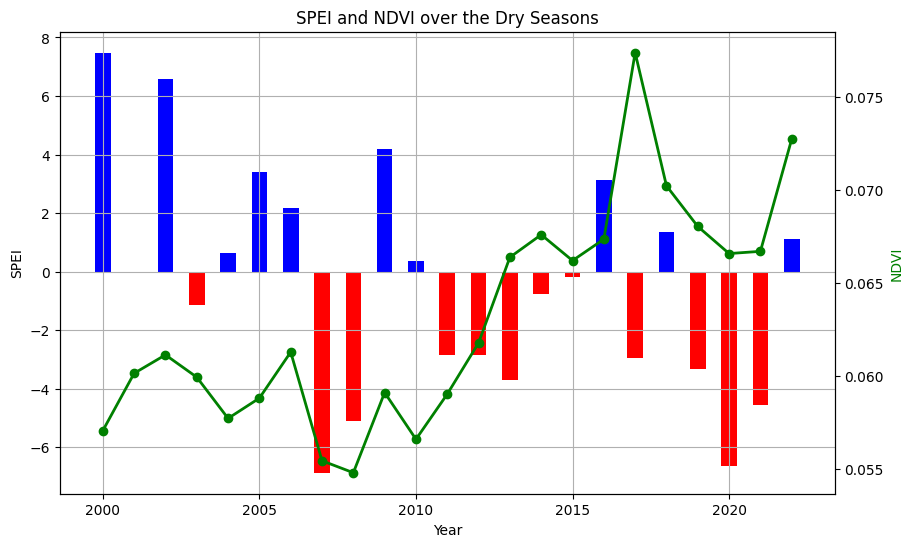

In [ ]:

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot SPEI as bars, red for positive and blue for negative
colors = ['blue' if val > 0 else 'red' for val in Dry_season_median['SPEI']]
ax1.bar(Dry_season_median['dry_season'], Dry_season_median['SPEI'], color=colors, width=0.5, label='SPEI')
ax1.set_xlabel('Year')
ax1.set_ylabel('SPEI', color='black')

# Create a second y-axis for NDVI
ax2 = ax1.twinx()
ax2.plot(Dry_season_median['dry_season'], Dry_season_median['NDVI'], color='green', marker='o', label='NDVI', linewidth=2)
ax2.set_ylabel('NDVI', color='green')

# Title and grid
plt.title('SPEI and NDVI over the Dry Seasons')
ax1.grid(True)

# Show plot
plt.show()


In [ ]:
def calculate_pearson(group):
    return group['NDVI'].corr(group['SPEI'])

# Group by 'Site_Name' and calculate the Pearson correlation
Dry_season_correlations = Dry_season_merge.groupby('Site_Name').apply(calculate_pearson).reset_index()

# Rename the columns for clarity
Dry_season_correlations.columns = ['Site_Name', 'Pearson_Correlation']

# Display the resulting DataFrame
#print(Dry_season_correlations)

# Sort the DataFrame by the 'Pearson_Correlation' column in descending order
Dry_season_correlations = Dry_season_correlations.sort_values(by='Pearson_Correlation', ascending=False).reset_index(drop=True)

Dry_season_correlations = Dry_season_correlations.merge(cluster_df, on='Site_Name', how='inner')

# Display the sorted DataFrame
print(Dry_season_correlations)

               Site_Name  Pearson_Correlation  cluster
0         Canadon Blanco             0.527001        2
1             Don Julian             0.442553        4
2          San Sebastian             0.398292        4
3           La Querencia             0.377221        4
4          Aguada Amarga             0.358860        2
..                   ...                  ...      ...
92            Chali Aike            -0.322525        1
93     El Camaruco S.R.L            -0.333916        1
94  Don Carlos Invernada            -0.336661        1
95            La Paulina            -0.354759        1
96             La Cancha            -0.587806        1

[97 rows x 3 columns]


Make a bar plot of the clusters

<ipython-input-184-e7792d794cdc>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(x='cluster', y='Pearson_Correlation', data=Dry_season_correlations_filtered, ci='sd')


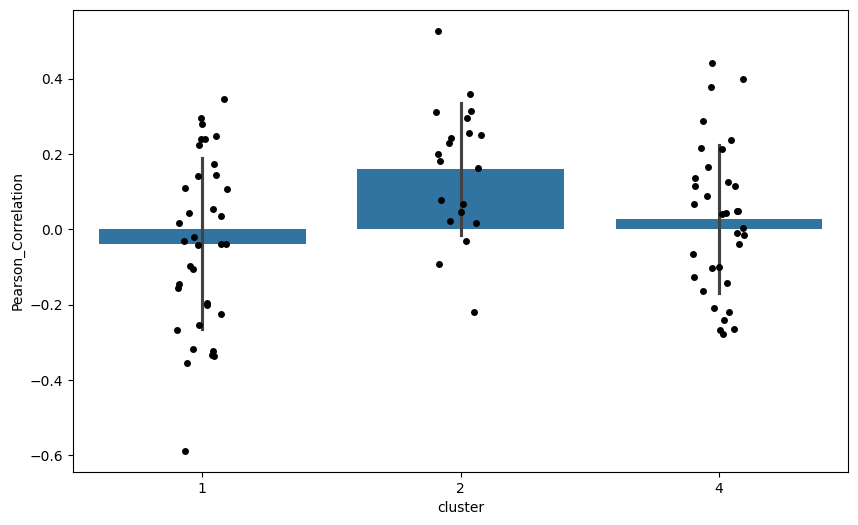

In [ ]:
# Filter out cluster 3
Dry_season_correlations_filtered = Dry_season_correlations[Dry_season_correlations['cluster'] != 3]

# Recreate the plot without cluster 3
plt.figure(figsize=(10, 6))

# Create a bar plot with points and error bars
sns.barplot(x='cluster', y='Pearson_Correlation', data=Dry_season_correlations_filtered, ci='sd')

# Adding points to the bar plot
sns.stripplot(x='cluster', y='Pearson_Correlation', data=Dry_season_correlations_filtered, color='black', jitter=True)

# Display the plot
plt.show()


In [ ]:
Plotting_Dry_season_merge

,dry_season,Site_Name,SPEI,NDVI
0,2000,1 Rio Guenguel,1.690957,0.04160
1,2000,1 San Felipe,12.199412,0.05835
2,2000,1 San Jose,10.439488,0.04390
3,2000,2 Rio Guenguel,4.762868,0.04650
4,2000,2 San Felipe,12.326591,0.05800
...,...,...,...,...
2226,2022,Seis Hermanos,7.157808,0.03140
2227,2022,Telleriarte,11.801762,0.07460
2228,2022,Tureo,3.838178,0.03915
2229,2022,Valdes Creek Secc. El Piquillin,3.767759,0.08610
